In [ ]:
# ---------------------------------------------------------
# GOOGLE COLAB SETUP
# ---------------------------------------------------------
import sys
import os
import subprocess

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Detected Google Colab environment.")
    
    # ---------------------------------------------------------
    # 1. Installation Check
    # ---------------------------------------------------------
    needs_install = False
    
    # Check if pot is installed
    try:
        import ot
    except ImportError:
        print("POT (Python Optimal Transport) not found. Installation required.")
        needs_install = True
        
    # Check if geomloss is installed
    try:
        import geomloss
    except ImportError:
        print("GeomLoss not found. Installation required.")
        needs_install = True

    # Check if tqdm is installed
    try:
        import tqdm
    except ImportError:
        print("tqdm not found. Installation required.")
        needs_install = True

    if needs_install:
        print("Installing required packages (this may take a minute)...")
        !pip install -q -U pot geomloss tqdm
        
        print("\n" + "="*80)
        print("INSTALLATION COMPLETE.")
        print("="*80 + "\n")
    else:
        print("Environment appears correct. Skipping installation.")

    # ---------------------------------------------------------
    # 2. Download Dataset
    # ---------------------------------------------------------
    # MNIST is downloaded automatically by torchvision in the next cells.
    print("MNIST dataset will be downloaded by torchvision.")
        
else:
    print("Not running in Google Colab. Assuming local environment.")

In [ ]:
# Setup: Install POT and import libraries
import numpy as np
import matplotlib.pyplot as plt
import ot
import torch
from torchvision import datasets

print(f"NumPy version: {np.__version__}")
print("Libraries imported successfully.")

Libraries imported successfully.


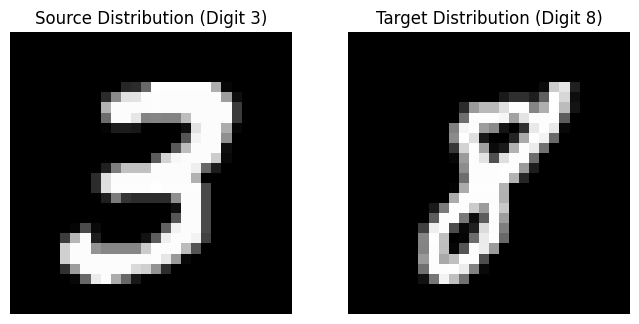

In [5]:
# Data Prep: Load MNIST via torchvision and select two digits
# Download MNIST (PIL images) and convert to numpy arrays
mnist_train = datasets.MNIST(root='.', train=True, download=True)
x_train = np.array([np.array(img, dtype=np.float64) for img, _ in mnist_train])
y_train = np.array([label for _, label in mnist_train])

# Select a '3' and an '8'
idx3 = np.where(y_train == 3)[0][0]
idx8 = np.where(y_train == 8)[0][0]

img1 = x_train[idx3].astype(np.float64)
img2 = x_train[idx8].astype(np.float64)

# Normalize so pixel intensities sum to 1 (probability distributions)
img1 /= img1.sum()
img2 /= img2.sum()

# Flatten for processing
n_pixels = 28 * 28
a = img1.flatten()
b = img2.flatten()

# Visualize the chosen images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title("Source Distribution (Digit 3)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title("Target Distribution (Digit 8)")
plt.axis('off')
plt.show()

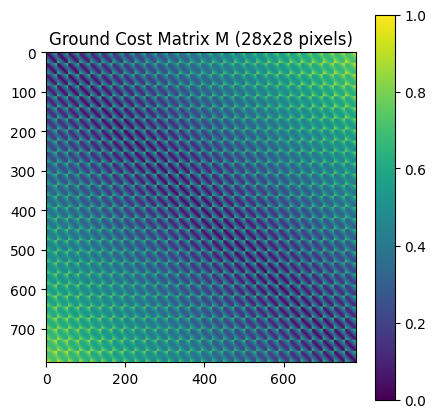

In [6]:
# Geometry: Create Ground Cost Matrix based on pixel coordinates

# Create a grid of coordinates (x, y)
x, y = np.mgrid[0:28, 0:28]
coords = np.vstack((x.flatten(), y.flatten())).T

# Compute Euclidean distance matrix between all pairs of pixels
# M[i, j] is the distance between pixel i and pixel j
M = ot.dist(coords, coords, metric='euclidean')

# Normalize M for numerical stability (optional but recommended)
M /= M.max()

plt.figure(figsize=(5, 5))
plt.imshow(M, cmap='viridis')
plt.title("Ground Cost Matrix M (28x28 pixels)")
plt.colorbar()
plt.show()

In [7]:
# Metric Comparison: Euclidean vs. Earth Mover's Distance

# 1. Euclidean Distance (L2 Norm)
# Does not consider geometry; treats pixels as independent features.
euclidean_dist = np.linalg.norm(a - b)

# 2. Earth Mover's Distance (Wasserstein-1)
# Computes the minimum cost to transport mass from 'a' to 'b' given cost matrix M.
# ot.emd2 returns the cost value.
emd_dist = ot.emd2(a, b, M)

print(f"Euclidean Distance: {euclidean_dist:.4f}")
print(f"Earth Mover's Distance: {emd_dist:.4f}")

# Comment:
# Notice that EMD gives a meaningful distance based on the geometry of the image.
# Even if two digits are non-overlapping, EMD will be proportional to how far the pixels need to move.
# Euclidean distance would just be constant for non-overlapping shapes (sqrt(sum(a^2) + sum(b^2))).

Euclidean Distance: 0.0752
Earth Mover's Distance: 0.0436


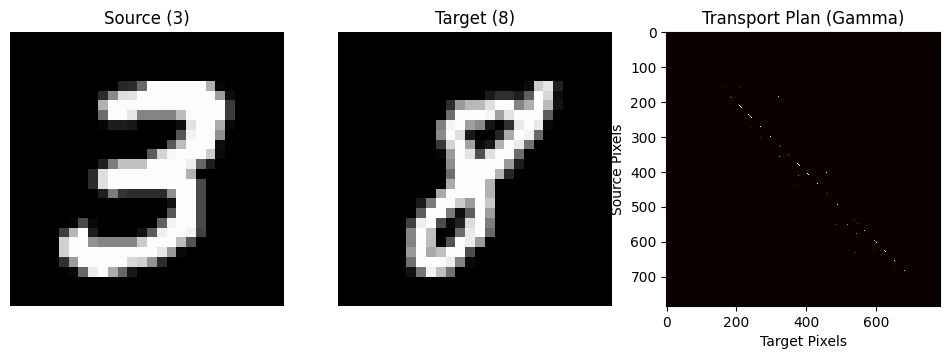

The Transport Plan shows which source pixels map to which target pixels.


In [8]:
# Visualization: Transport Plan

# Compute the optimal transport plan (matrix gamma)
# gamma[i, j] is the amount of mass moved from pixel i in source to pixel j in target.
gamma = ot.emd(a, b, M)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title("Source (3)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title("Target (8)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gamma, cmap='hot', interpolation='nearest')
plt.title("Transport Plan (Gamma)")
plt.xlabel("Target Pixels")
plt.ylabel("Source Pixels")
plt.show()

print("The Transport Plan shows which source pixels map to which target pixels.")

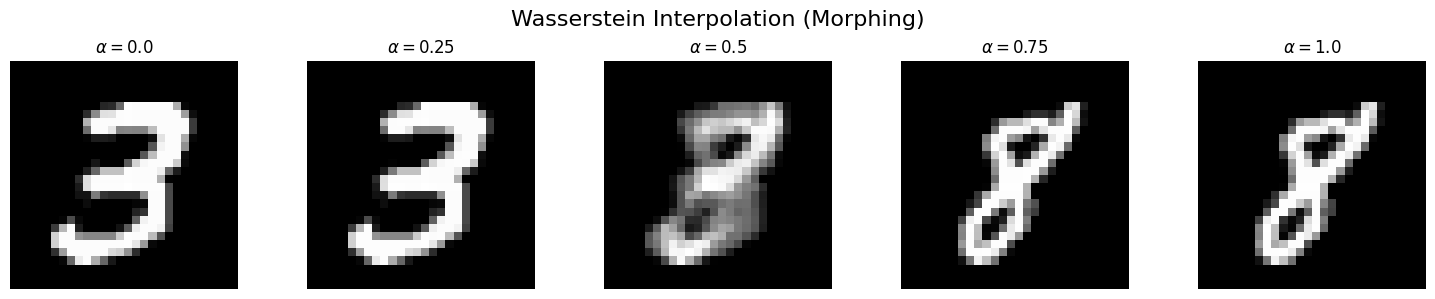

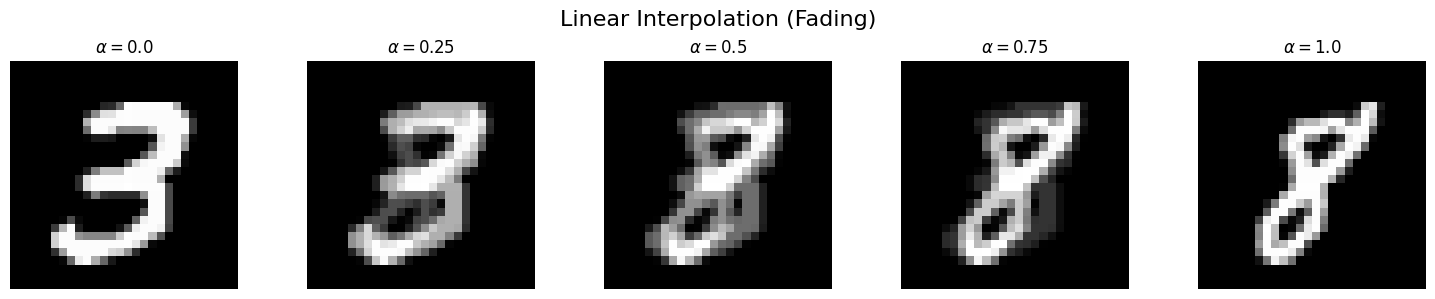

In [9]:
# Interpolation: Wasserstein Barycenters
# We will compute the interpolation between the two images for different weights alpha.

# Stack the two flattened images into a matrix A (d x 2)
A = np.vstack((a, b)).T

# Regularization parameter for Sinkhorn (entropic regularization)
# A small value makes it closer to exact OT but slower/less stable.
reg = 1e-3 

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

plt.figure(figsize=(15, 3))

for i, alpha in enumerate(alphas):
    # Weights for the barycenter [1-alpha, alpha]
    weights = np.array([1 - alpha, alpha])
    
    # Compute Wasserstein barycenter
    # This finds the distribution that minimizes the weighted sum of Wasserstein distances to the inputs.
    barycenter = ot.bregman.barycenter(A, M, reg, weights)
    
    # Reshape back to 28x28 image
    img_interp = barycenter.reshape(28, 28)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_interp, cmap='gray')
    plt.title(f"$\\alpha={alpha}$")
    plt.axis('off')

plt.suptitle("Wasserstein Interpolation (Morphing)", fontsize=16)
plt.tight_layout()
plt.show()

# Comparison with Linear Interpolation
plt.figure(figsize=(15, 3))
for i, alpha in enumerate(alphas):
    # Linear interpolation
    img_linear = (1 - alpha) * img1 + alpha * img2
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_linear, cmap='gray')
    plt.title(f"$\\alpha={alpha}$")
    plt.axis('off')

plt.suptitle("Linear Interpolation (Fading)", fontsize=16)
plt.tight_layout()
plt.show()

# Comment:
# Wasserstein interpolation moves the mass physically (morphing),
# while linear interpolation just fades one image out and the other in.

## Animation: Morphing vs Fading

The static plots above show the interpolation at fixed steps. Below, we generate an animation to visualize the smooth transition.

In [10]:
from matplotlib import animation
from IPython.display import HTML

# Setup figure for animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

def update(frame):
    alpha = frame / 20.0  # 20 frames from 0 to 1
    weights = np.array([1 - alpha, alpha])
    
    # Wasserstein
    barycenter = ot.bregman.barycenter(A, M, reg, weights)
    img_interp = barycenter.reshape(28, 28)
    
    # Linear
    img_linear = (1 - alpha) * img1 + alpha * img2
    
    ax1.clear()
    ax1.imshow(img_interp, cmap='gray')
    ax1.set_title(f"Wasserstein (alpha={alpha:.2f})")
    ax1.axis('off')
    
    ax2.clear()
    ax2.imshow(img_linear, cmap='gray')
    ax2.set_title(f"Linear (alpha={alpha:.2f})")
    ax2.axis('off')

anim = animation.FuncAnimation(fig, update, frames=21, interval=200)
plt.close() # Prevent static display
HTML(anim.to_jshtml())

## Embedding with Optimal Transport Distances

We can use the Earth Mover's Distance as a metric to embed the digits into a 2D space. This allows us to visualize how "close" different digits are in terms of their geometry.

Since computing OT distances is expensive, we will select a small subset of the dataset (e.g., 10 images per digit).

In [ ]:
# Data Selection for t-SNE
# We'll select a subset of images to compute the pairwise OT distance matrix.

n_per_digit = 50
subset_indices = []
subset_labels = []

for digit in range(10):
    indices = np.where(y_train == digit)[0][:n_per_digit]
    subset_indices.extend(indices)
    subset_labels.extend([digit] * n_per_digit)

subset_images = x_train[subset_indices].astype(np.float64)
subset_labels = np.array(subset_labels)

# ---------------------------------------------------------
# COARSENING (Downsampling)
# ---------------------------------------------------------
# Reduce 28x28 -> 14x14 to speed up OT computation
# We average 2x2 blocks
print(f"Original shape: {subset_images.shape}")
subset_images = subset_images.reshape(-1, 14, 2, 14, 2).mean(axis=(2, 4))
print(f"Coarsened shape: {subset_images.shape}")

# Normalize
subset_images = subset_images.reshape(len(subset_images), -1) # Flatten
subset_images /= subset_images.sum(axis=1, keepdims=True)

print(f"Selected {len(subset_images)} images ({n_per_digit} per digit).")
print(f"Points per image: {subset_images.shape[1]}")

Selected 500 images (50 per digit).


Using 8 cores for computation.
Computing pairwise Wasserstein distances...
Total pairs to compute: 124750


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  60 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 952 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 2968 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 7896 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done 14232 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done 21720 tasks      | elapsed:   22.6s
[Parallel(n_jobs=8)]: Done 30360 tasks      | elapsed:   27.6s
[Parallel(n_jobs=8)]: Done 40152 tasks      | elapsed:   32.9s
[Parallel(n_jobs=8)]: Done 51096 tasks      | elapsed:   39.6s
[Parallel(n_jobs=8)]: Done 63192 tasks      | elapsed:   47.8s
[Parallel(n_jobs=8)]: Done 76440 tasks      | elapsed:   56.4s
[Parallel(n_jobs=8)]: Done 90840 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 106392 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 123096 tasks      | ela

Distance matrix computed.


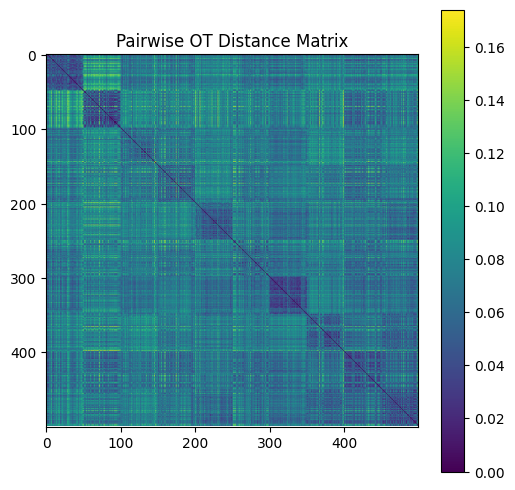

In [ ]:
# Compute Pairwise OT Distance Matrix (Parallelized or GPU)
import multiprocessing
from joblib import Parallel, delayed
import time
try:
    from tqdm.auto import tqdm
except ImportError:
    def tqdm(x, **kwargs): return x

# Check for GPU
try:
    import torch
    import geomloss
    USE_GPU = torch.cuda.is_available()
except ImportError:
    USE_GPU = False

if USE_GPU:
    print("GPU detected. Using GeomLoss for accelerated Sinkhorn distances.")
    
    def compute_pairwise_matrix_gpu(images, coords, batch_size=10):
        # images: (N, n_features)
        # coords: (n_features, 2)
        
        import gc
        # Clear memory before starting
        gc.collect()
        torch.cuda.empty_cache()
        
        device = torch.device("cuda")
        N = len(images)
        n_features = images.shape[1]
        
        print(f"Moving data to GPU... (Batch size: {batch_size}, Features: {n_features})")
        # Prepare data
        # Weights must be positive and sum to 1
        w = torch.tensor(images, dtype=torch.float32).to(device)
        x = torch.tensor(coords, dtype=torch.float32).to(device)
        
        # Define Loss (Sinkhorn ~ EMD)
        # p=1 corresponds to Euclidean distance cost (|x-y|)
        # blur=0.05 is small enough for good approximation
        # scaling=0.9 helps with convergence speed
        loss_fn = geomloss.SamplesLoss("sinkhorn", p=1, blur=0.05, scaling=0.9)
        
        D_mat = np.zeros((N, N))
        
        print("Starting GPU computation...")
        
        # Loop over blocks
        for i in tqdm(range(0, N, batch_size), desc="Computing Rows"):
            # print(f"Processing row batch {i}/{N}...")
            end_i = min(i + batch_size, N)
            len_i = end_i - i
            
            # Prepare batch I
            # Shape: (len_i, 1, n_features, 2)
            w_i = w[i:end_i].unsqueeze(1) # (len_i, 1, n_features)
            x_i = x.unsqueeze(0).unsqueeze(0).expand(len_i, 1, -1, -1) # (len_i, 1, n_features, 2)
            
            # OPTIMIZATION: Only loop j starting from i (Upper Triangle)
            for j in range(i, N, batch_size):
                end_j = min(j + batch_size, N)
                len_j = end_j - j
                
                # Prepare batch J
                # Shape: (1, len_j, n_features, 2)
                w_j = w[j:end_j].unsqueeze(0) # (1, len_j, n_features)
                x_j = x.unsqueeze(0).unsqueeze(0).expand(1, len_j, -1, -1) # (1, len_j, n_features, 2)
                
                # Broadcast to (len_i, len_j, n_features, 2)
                # We flatten to (len_i * len_j, n_features, 2) for geomloss
                # NOTE: We must use .contiguous() because geomloss uses .view() internally
                
                w_i_flat = w_i.expand(-1, len_j, -1).contiguous().view(-1, n_features)
                x_i_flat = x_i.expand(-1, len_j, -1, -1).contiguous().view(-1, n_features, 2)
                
                w_j_flat = w_j.expand(len_i, -1, -1).contiguous().view(-1, n_features)
                x_j_flat = x_j.expand(len_i, -1, -1, -1).contiguous().view(-1, n_features, 2)
                
                # Compute loss
                with torch.no_grad():
                    # Returns (Batch,)
                    dists = loss_fn(w_i_flat, x_i_flat, w_j_flat, x_j_flat)
                
                # Reshape and store
                block_res = dists.view(len_i, len_j).cpu().numpy()
                D_mat[i:end_i, j:end_j] = block_res
                
                # Symmetric fill (avoid recomputing lower triangle)
                if i != j:
                    D_mat[j:end_j, i:end_i] = block_res.T
                
                # Clean up intermediate tensors
                del w_i_flat, x_i_flat, w_j_flat, x_j_flat, dists, block_res
                
            # Clear cache after each row block to prevent fragmentation
            torch.cuda.empty_cache()
                
        return D_mat

    # Run GPU computation
    start_time = time.time()
    
    # Ensure coords match the image size (important if we coarsened the data)
    n_features = subset_images.shape[1]
    side = int(np.sqrt(n_features))
    
    # Regenerate coords to match the current image resolution
    x_grid, y_grid = np.mgrid[0:side, 0:side]
    coords = np.vstack((x_grid.flatten(), y_grid.flatten())).T
    
    # If we are using coarsened images (14x14), the coordinates are 0..13.
    # This is fine for relative distances.
        
    D_ot = compute_pairwise_matrix_gpu(subset_images, coords, batch_size=20)
    print(f"GPU Computation time: {time.time() - start_time:.2f}s")

else:
    print("GPU not found or libraries missing. Using CPU parallel processing.")
    n_cores = multiprocessing.cpu_count()
    print(f"Using {n_cores} cores for computation.")

    n_samples = len(subset_images)
    D_ot = np.zeros((n_samples, n_samples))

    # Define helper function for parallel execution
    def compute_ot_pair(i, j, img_i, img_j, M):
        # ot.emd2 returns the transport cost
        val = ot.emd2(img_i, img_j, M)
        return i, j, val

    print("Computing pairwise Wasserstein distances...")
    
    # Ensure M matches the image size
    n_features = subset_images.shape[1]
    side = int(np.sqrt(n_features))
    x_grid, y_grid = np.mgrid[0:side, 0:side]
    coords = np.vstack((x_grid.flatten(), y_grid.flatten())).T
    M = ot.dist(coords, coords, metric='euclidean')
    M /= M.max()

    # Create list of pairs (upper triangle)
    pairs = [(i, j) for i in range(n_samples) for j in range(i + 1, n_samples)]
    print(f"Total pairs to compute: {len(pairs)}")

    # Run in parallel with joblib verbose output
    results = Parallel(n_jobs=n_cores, verbose=5)(
        delayed(compute_ot_pair)(i, j, subset_images[i], subset_images[j], M) 
        for i, j in pairs
    )

    # Fill the matrix
    for i, j, val in results:
        D_ot[i, j] = val
        D_ot[j, i] = val

print("Distance matrix computed.")

plt.figure(figsize=(6, 6))
plt.imshow(D_ot, cmap='viridis')
plt.title("Pairwise OT Distance Matrix")
plt.colorbar()
plt.show()

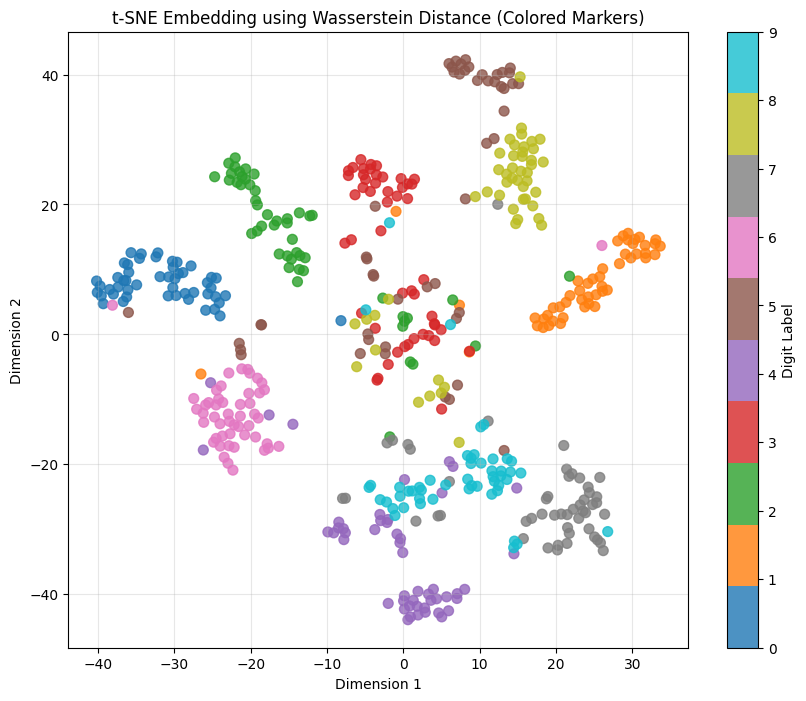

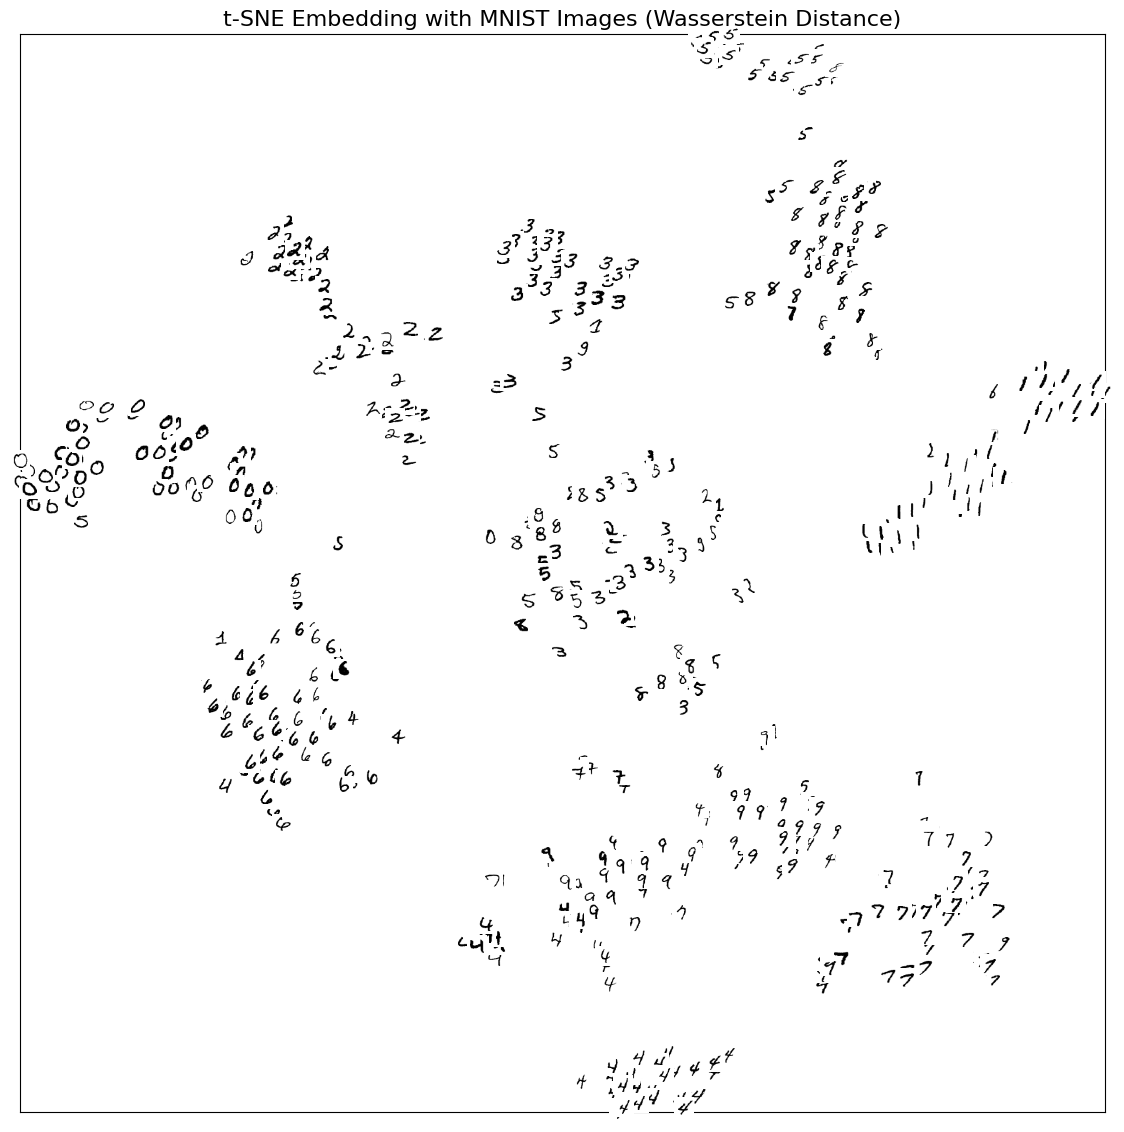

In [15]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# t-SNE Embedding with precomputed distance matrix
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42, perplexity=15)
embedding = tsne.fit_transform(D_ot)

# 1. Standard Visualization (Colored Markers)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=subset_labels, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, label='Digit Label')
plt.title("t-SNE Embedding using Wasserstein Distance (Colored Markers)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Visualization with Images
def plot_embedding_images(X, images, title=None):
    # Normalize coordinates to [0, 1] for easier scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(14, 14))
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        # Reshape and normalize for display (0-1 range)
        img = images[i].reshape(28, 28)
        img = img / img.max() 
        
        # Create image box
        # zoom=0.5 controls the size of the images on the plot
        # cmap='gray_r' inverts the colors (black digit on white background)
        imagebox = OffsetImage(img, zoom=0.5, cmap='gray_r') 
        ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]), frameon=False, pad=0.0)
        ax.add_artist(ab)
    
    plt.xticks([]), plt.yticks([])
    if title:
        plt.title(title, fontsize=16)
    plt.show()

plot_embedding_images(embedding, subset_images, "t-SNE Embedding with MNIST Images (Wasserstein Distance)")

## Prototypes and Outliers

Using the pairwise Wasserstein distances, we can identify which images are most central to their cluster (prototypes) and which are most distant (outliers).

*   **Prototype:** The image with the minimum average distance to all other images of the same digit.
*   **Outlier:** The image with the maximum average distance to all other images of the same digit.

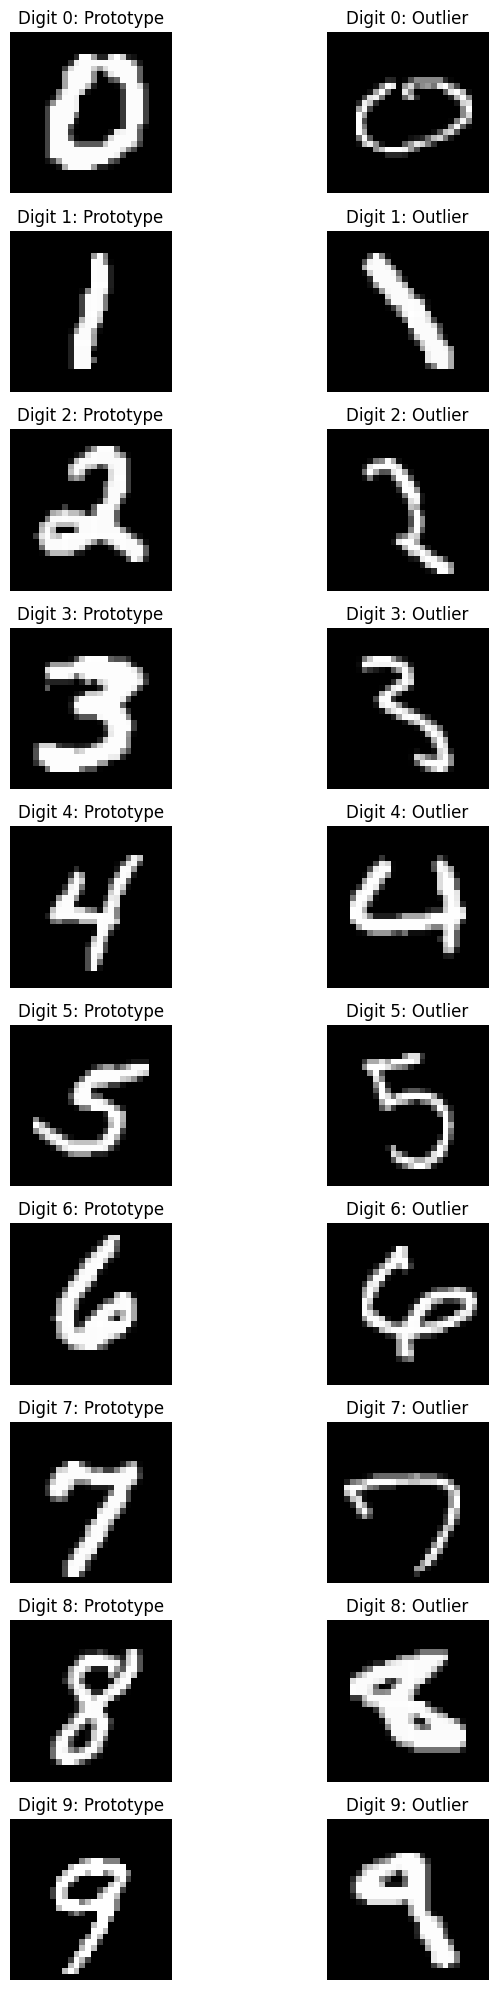

In [16]:
# Find Most and Least Representative Digits
# For each digit, we find the sample with the smallest average OT distance to others of the same class (prototype)
# and the largest average OT distance (outlier).

plt.figure(figsize=(8, 20))

for digit in range(10):
    # Get indices for this digit
    indices = np.where(subset_labels == digit)[0]
    
    # Extract sub-matrix of distances for this digit
    # D_ot is the precomputed NxN distance matrix
    sub_matrix = D_ot[np.ix_(indices, indices)]
    
    # Compute average distance of each sample to all others in the class
    avg_dist = sub_matrix.mean(axis=1)
    
    # Find min (prototype) and max (outlier)
    idx_proto = indices[np.argmin(avg_dist)]
    idx_outlier = indices[np.argmax(avg_dist)]
    
    # Plot Prototype
    plt.subplot(10, 2, 2 * digit + 1)
    img_proto = subset_images[idx_proto].reshape(28, 28)
    plt.imshow(img_proto, cmap='gray')
    plt.title(f"Digit {digit}: Prototype")
    plt.axis('off')
    
    # Plot Outlier
    plt.subplot(10, 2, 2 * digit + 2)
    img_outlier = subset_images[idx_outlier].reshape(28, 28)
    plt.imshow(img_outlier, cmap='gray')
    plt.title(f"Digit {digit}: Outlier")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Morphological Confusion Matrix

The grid below shows the "confusion candidates" between digits.
*   **Row $i$, Column $j$:** Displays the specific image of **Digit $i$** that has the smallest average Wasserstein distance to the cluster of **Digit $j$**.
*   This answers questions like: *"Which '2' looks most like a '7'?"* or *"Which '5' looks most like a '6'?"*
*   The diagonal elements $(i, i)$ correspond to the prototypes (most representative images) found above.

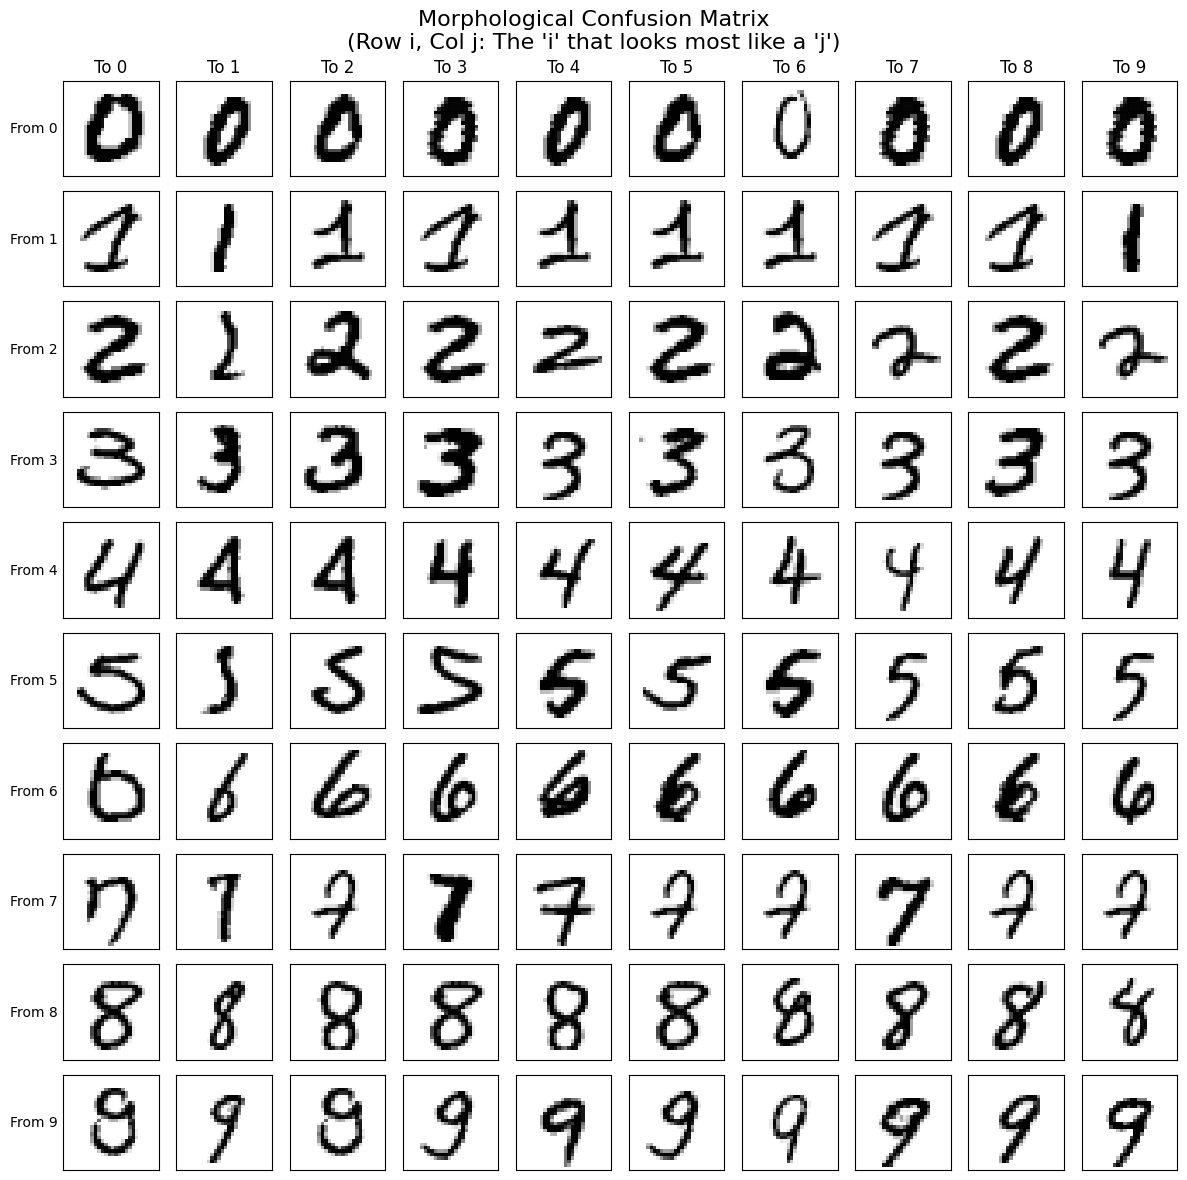

In [17]:
# Visualize the "Confusion Matrix" of Morphologies
n_classes = 10
plt.figure(figsize=(12, 12))

for i in range(n_classes):
    indices_i = np.where(subset_labels == i)[0]
    for j in range(n_classes):
        indices_j = np.where(subset_labels == j)[0]
        
        # Extract sub-matrix of distances between class i (rows) and class j (cols)
        # D_ot is the precomputed NxN distance matrix
        dists = D_ot[np.ix_(indices_i, indices_j)]
        
        # Find sample in i that is closest to class j on average
        # We average over the columns (target class j) to find how close each 'i' is to the 'j' cluster
        avg_dists = dists.mean(axis=1)
        best_idx_local = np.argmin(avg_dists)
        best_idx_global = indices_i[best_idx_local]
        
        # Plot
        plt.subplot(n_classes, n_classes, i * n_classes + j + 1)
        img = subset_images[best_idx_global].reshape(28, 28)
        plt.imshow(img, cmap='gray_r') # Inverted gray for better visibility of thin strokes
        
        # Labels
        if i == 0:
            plt.title(f"To {j}")
        if j == 0:
            plt.ylabel(f"From {i}", rotation=0, ha='right', va='center')
            
        plt.xticks([])
        plt.yticks([])

plt.suptitle("Morphological Confusion Matrix\n(Row i, Col j: The 'i' that looks most like a 'j')", fontsize=16)
plt.tight_layout()
plt.show()